In [1]:
# Use the value of the THG calculated (no pump, probe only)
# in another notebook on a mesh of coefficients and
# "fit" to the experimental values.
# Since we just optimize on a given mesh it is not really a fit.

In [2]:
import math
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [3]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

# Experimental data

In [4]:
# Save directory for the analyses.
saveDir = "./data/06/fit_data_no_pump_gamma_coeffs"

In [5]:
# Load the experimental data.
power_in = 7.0e-3 # input power in W
exp_data = np.loadtxt("./data/from_omid/thg_vs_ef_no_pulse.csv", delimiter=",")
exp_ef = exp_data[:,0] * 1.0e-3  # convert to eV
exp_thg_300K = exp_data[:,1] * 1.0e-12 / power_in  # pW, convert to efficiency
exp_thg_30K = exp_data[:,2] * 1.0e-12 / power_in  # pW, convert to efficiency

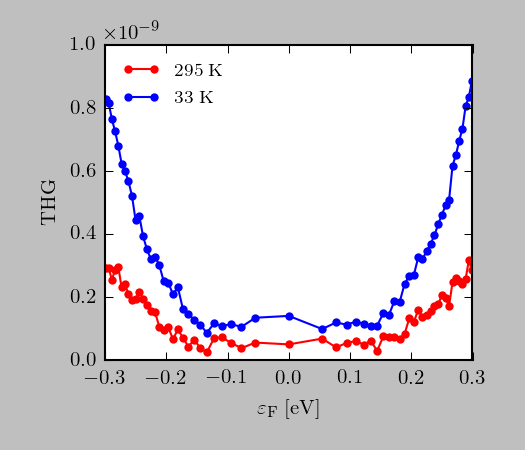

In [6]:
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(exp_ef, exp_thg_300K, "-or", ms=4.0, mew=0, label=r"$295~{\rm K}$")
plt.plot(exp_ef, exp_thg_30K, "-ob", ms=4.0, mew=0, label=r"$33~{\rm K}$")
#plt.xlim([0.050, 0.250])
plt.ylim([0.0, 1.0e-9])
plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eV}]$")
plt.ylabel(r"${\rm THG}$")
plt.legend(frameon=False,loc="upper left", fontsize=9)
#plt.savefig("%s/thg_vs_ef_04.png" % saveDir, dpi=300)

# 1d mesh

In [ ]:
def optimize_1d(p):
    calcDir = p["calcDir"]
    eF_list = np.loadtxt("%s/%s.csv" % (calcDir, p["eF_list"]), delimiter=", ")
    gamma_coeff_list = np.loadtxt("%s/%s.csv" % (calcDir, p["gamma_coeff_list"]), delimiter=", ")
    thg_list = np.loadtxt("%s/%s.csv" % (calcDir, p["thg_list"]), delimiter=", ")

    # Select the experimental data within the calculated range of Fermi energies.
    exp_sel = [i for i,e in enumerate(exp_ef) if e >= eF_list[0] and e <= eF_list[-1]]
    exp_sel_ef = exp_ef[exp_sel]
    if p["tempK"] == "30":
        exp_sel_thg = exp_thg_30K[exp_sel]
    elif p["tempK"] == "300":
        exp_sel_thg = exp_thg_300K[exp_sel]
        
    # Calculate a cost function on the coefficients mesh.
    alpha_mesh = np.zeros(len(gamma_coeff_list))
    std2_mesh = np.zeros(len(gamma_coeff_list))
    for i1 in range(len(gamma_coeff_list)):
        # Interpolate calculated values on the experimental mesh.
        theo_func = interp1d(eF_list, thg_list[i1,:], kind="cubic")
        theo_thg = np.maximum(theo_func(exp_sel_ef), 1.0e-15)
        if p["linfit"]:
            # Multiply the theoretical data by the coefficients that
            # minimizes the standard deviation.
            alpha = np.dot(theo_thg, exp_sel_thg) / np.dot(theo_thg, theo_thg)
            std2 = np.sqrt( np.mean((exp_sel_thg - alpha * theo_thg)**2) )
        else:
            alpha = 1.0
            std2 = np.sqrt( np.mean((theo_thg - exp_sel_thg)**2) )
        std2_mesh[i1] = std2
        alpha_mesh[i1] = alpha

    # Plot the value of the standard deviation vs. the coefficient.
    mpl.style.use(["classic", "latex"])
    plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
    plt.axes([0.2, 0.2, 0.6, 0.7])
    plt.plot(np.log10(gamma_coeff_list), std2_mesh, "-ob", ms=3.0, mew=0.0)
    lxmin = np.floor(np.log10(gamma_coeff_list[0]))
    lxmax = np.ceil(np.log10(gamma_coeff_list[-1]))
    tk = np.arange(lxmin,lxmax+1)
    plt.xticks(tk, [r"$10^{%d}$" % t for t in tk])
    plt.yscale("log")
    plt.xlabel("$%s$" % p["coeff_xlabel"])
    plt.ylabel(r"standard deviation")
    plt.title(r"\scriptsize Theory vs.~Exp., $T_{\rm L} = %s~{\rm K}$" % p["tempK"])

    linfitlabel = "-linfit" if p["linfit"] else ""
    runlabel = "-%s" % p["runlabel"] if p["runlabel"] != "" else ""
    plotlabel = "%s_%sK%s%s" % (p["coeff_name"], p["tempK"], linfitlabel, runlabel)
    plt.savefig("%s/map_%s.png" % (saveDir, plotlabel), dpi=300);

    # Plot results of linear fit.
    if p["linfit"]:
        mpl.style.use(["classic", "latex"])
        plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
        plt.axes([0.2, 0.2, 0.6, 0.7])
        plt.plot(np.log10(gamma_coeff_list), np.log10(alpha_mesh), "-ob", ms=3.0, mew=0.0)
        lxmin = np.floor(np.log10(gamma_coeff_list[0]))
        lxmax = np.ceil(np.log10(gamma_coeff_list[-1]))
        tk = np.arange(lxmin,lxmax+1)
        plt.xticks(tk, [r"$10^{%d}$" % t for t in tk])
        tk = np.arange(-5,1)
        plt.yticks(tk, [r"$10^{%d}$" % t for t in tk])
        plt.xlabel("$%s$" % p["coeff_xlabel"])
        plt.ylabel(r"linear fit coeff.~$\alpha$")
        plt.title(r"\scriptsize Theory vs.~Exp., $T_{\rm L} = %s~{\rm K}$" % p["tempK"])
        plt.savefig("%s/alpha_%s.png" % (saveDir, plotlabel), dpi=300);

     # Plot the data where theory and experiment agree best.
    i1_opt = std2_mesh.argmin()
    ef_opt_mesh = np.linspace(eF_list[0], eF_list[-1], 51)
    theo_func_opt = interp1d(eF_list, thg_list[i1_opt,:], kind="cubic")
    thg_opt = alpha_mesh[i1_opt] * np.maximum(theo_func_opt(ef_opt_mesh), 1.0e-15)        

    c = "red" if p["tempK"] == "300" else "blue"
    mpl.style.use(["classic", "latex"])
    plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
    plt.axes([0.2, 0.2, 0.7, 0.7])
    plt.plot(ef_opt_mesh, thg_opt, "-", c=c)
    plt.plot(exp_sel_ef, exp_sel_thg, "o", c=c, ms=4.0, mew=0)
    #plt.xlim([0.050, 0.250])
    plt.ylim([0.0, 1.0e-9])
    plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eV}]$")
    plt.ylabel(r"${\rm THG}$")
    plt.title(r"\scriptsize $T_{\rm L} = %s~{\rm K}$" % p["tempK"])
    plt.figtext(0.23, 0.83, r"$%s = %.4f$" % (p["coeff_xlabel"], gamma_coeff_list[i1_opt]))
    if p["linfit"]:
        plt.figtext(0.23, 0.75, r"$\alpha = %.9f$" % alpha_mesh[i1_opt])
    plt.savefig("%s/fit_%s.png" % (saveDir, plotlabel), dpi=300);
        
    
p1 = {
    "calcDir": "./data/06/2023-08-15-14-27-17_coeff_const_30K",
    "eF_list": "eF_list",
    "gamma_coeff_list": "gammaConst_list",
    "thg_list": "thg_list",
    "tempK": "30",
    "linfit": True,
    "coeff_name": "const",
    "coeff_xlabel": r"\Gamma_{0}(T_{\rm L})~[{\rm eV}]",
    "runlabel": ""
}


p2 = {
    "calcDir": "./data/06/2023-08-15-14-35-01_coeff_const_300K",
    "eF_list": "eF_list",
    "gamma_coeff_list": "gammaConst_list",
    "thg_list": "thg_list",
    "tempK": "300",
    "linfit": True,
    "coeff_name": "const",
    "coeff_xlabel": r"\Gamma_{0}(T_{\rm L})~[{\rm eV}]",
    "runlabel": ""
}

optimize_1d(p1)
optimize_1d(p2)

# 2d mesh

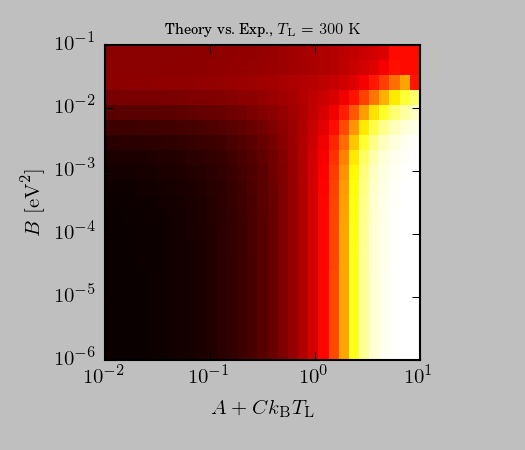

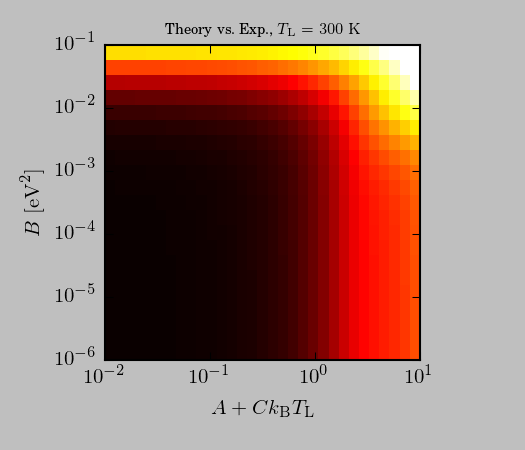

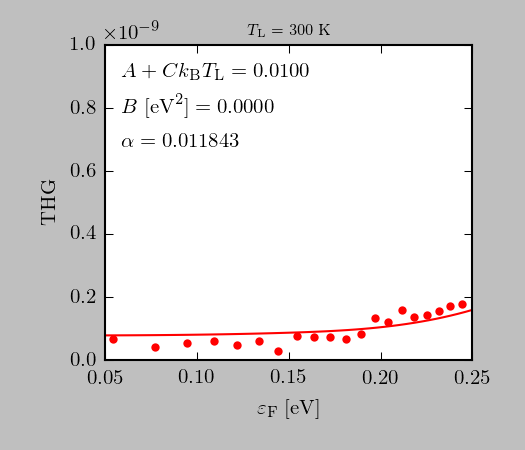

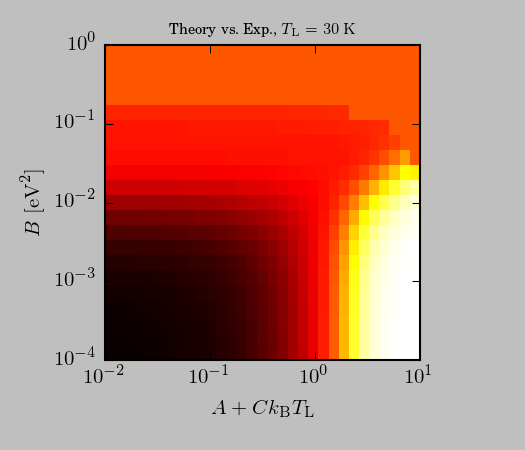

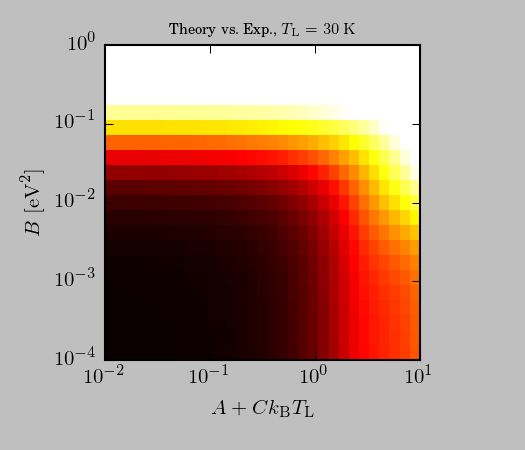

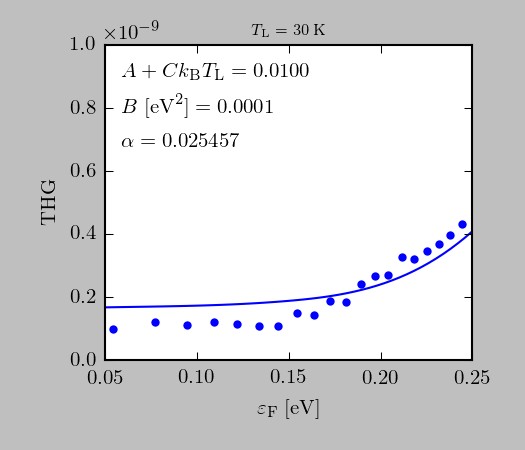

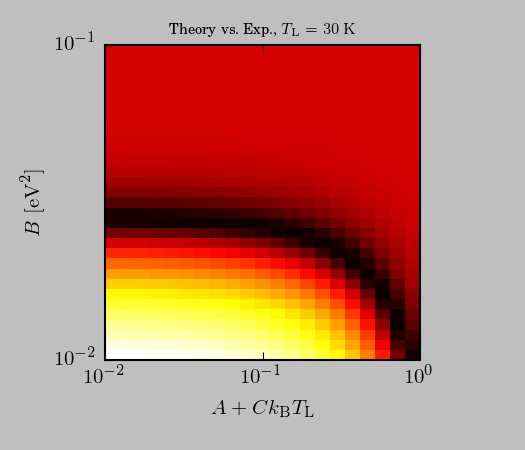

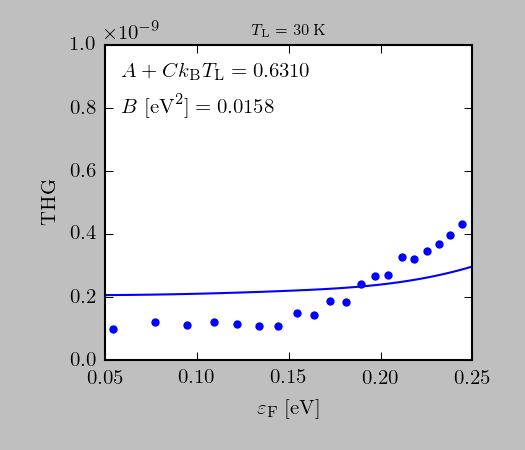

In [10]:
def optimize_2d(p):
    calcDir = p["calcDir"]
    eF_list = np.loadtxt("%s/%s.csv" % (calcDir, p["eF_list"]), delimiter=", ")
    gamma_coeff1_list = np.loadtxt("%s/%s.csv" % (calcDir, p["gamma_coeff1_list"]), delimiter=", ")
    gamma_coeff2_list = np.loadtxt("%s/%s.csv" % (calcDir, p["gamma_coeff2_list"]), delimiter=", ")
    thg_list = np.loadtxt("%s/%s.csv" % (calcDir, p["thg_list"]), delimiter=", ")
    # Rewrap the THG list as a 3D array.
    thg_3d = np.zeros((len(gamma_coeff1_list),len(gamma_coeff2_list),len(eF_list)))
    i_list = 0
    for i1 in range(len(gamma_coeff1_list)):
        for i2 in range(len(gamma_coeff2_list)):
            thg_3d[i1,i2,:] = thg_list[i_list,:]
            i_list = i_list + 1
    
    # Select the experimental data within the calculated range of Fermi energies.
    exp_sel = [i for i,e in enumerate(exp_ef) if e >= eF_list[0] and e <= eF_list[-1]]
    exp_sel_ef = exp_ef[exp_sel]
    if p["tempK"] == "30":
        exp_sel_thg = exp_thg_30K[exp_sel]
    elif p["tempK"] == "300":
        exp_sel_thg = exp_thg_300K[exp_sel]
        
    # Calculate a cost function on the coefficients mesh.
    alpha_mesh = np.zeros((len(gamma_coeff1_list),len(gamma_coeff2_list)))
    std2_mesh = np.zeros((len(gamma_coeff1_list),len(gamma_coeff2_list)))
    for i1 in range(len(gamma_coeff1_list)):
        for i2 in range(len(gamma_coeff2_list)):
            # Interpolate calculated values on the experimental mesh.
            theo_func = interp1d(eF_list, thg_3d[i1,i2,:], kind="cubic")
            theo_thg = np.maximum(theo_func(exp_sel_ef), 1.0e-15)
            if p["linfit"]:
                # Multiply the theoretical data by the coefficients that
                # minimizes the standard deviation.
                alpha = np.dot(theo_thg, exp_sel_thg) / np.dot(theo_thg, theo_thg)
                std2 = np.sqrt( np.mean((exp_sel_thg - alpha * theo_thg)**2) )
            else:
                alpha = 1.0
                std2 = np.sqrt( np.mean((theo_thg - exp_sel_thg)**2) )
            std2_mesh[i1,i2] = std2
            alpha_mesh[i1,i2] = alpha

    # Plot the value of the standard deviation vs. the coefficients.
    lx = np.log10(gamma_coeff1_list)
    ly = np.log10(gamma_coeff2_list)
    lxmin = np.floor(np.log10(gamma_coeff1_list[0]))
    lxmax = np.ceil(np.log10(gamma_coeff1_list[-1]))
    lymin = np.floor(np.log10(gamma_coeff2_list[0]))
    lymax = np.ceil(np.log10(gamma_coeff2_list[-1]))
                                         
    mpl.style.use(["classic", "latex"])
    plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
    ax1 = plt.axes([0.2, 0.2, 0.6, 0.7])
    ax1.imshow(np.log10(std2_mesh.transpose()), origin="lower", aspect="auto", interpolation="none",
               extent=(lx[0],lx[-1],ly[0],ly[-1]),cmap="hot")
    tk = np.arange(lxmin,lxmax+1)
    plt.xticks(tk, [r"$10^{%d}$" % t for t in tk])
    tk = np.arange(lymin,lymax+1)
    plt.yticks(tk, [r"$10^{%d}$" % t for t in tk])
    plt.xlabel("$%s$" % p["coeff1_xlabel"])
    plt.ylabel("$%s$" % p["coeff2_xlabel"])
    plt.title(r"\scriptsize Theory vs.~Exp., $T_{\rm L} = %s~{\rm K}$" % p["tempK"])

    linfitlabel = "-linfit" if p["linfit"] else ""
    runlabel = "-%s" % p["runlabel"] if p["runlabel"] != "" else ""
    plotlabel = "%s-%s_%sK%s%s" % (p["coeff1_name"], p["coeff2_name"], p["tempK"], linfitlabel, runlabel)
    plt.savefig("%s/map_%s.png" % (saveDir, plotlabel), dpi=300);

    # Plot results of linear fit.
    if p["linfit"]:
        mpl.style.use(["classic", "latex"])
        plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
        ax1 = plt.axes([0.2, 0.2, 0.6, 0.7])
        ax1.imshow(np.log10(alpha_mesh.transpose()), origin="lower", aspect="auto", interpolation="none",
                   extent=(lx[0],lx[-1],ly[0],ly[-1]),cmap="hot")
                         
        tk = np.arange(lxmin,lxmax+1)
        plt.xticks(tk, [r"$10^{%d}$" % t for t in tk])
        tk = np.arange(lymin,lymax+1)
        plt.yticks(tk, [r"$10^{%d}$" % t for t in tk])
        plt.xlabel("$%s$" % p["coeff1_xlabel"])
        plt.ylabel("$%s$" % p["coeff2_xlabel"])
        plt.title(r"\scriptsize Theory vs.~Exp., $T_{\rm L} = %s~{\rm K}$" % p["tempK"])
        plt.savefig("%s/alpha_%s.png" % (saveDir, plotlabel), dpi=300);

    # Plot the data where theory and experiment agree best.
    i1_opt,i2_opt = np.unravel_index(std2_mesh.argmin(), std2_mesh.shape)
    ef_opt_mesh = np.linspace(eF_list[0], eF_list[-1], 51)
    theo_func_opt = interp1d(eF_list, thg_3d[i1_opt,i2_opt,:], kind="cubic")
    thg_opt = alpha_mesh[i1_opt, i2_opt] * np.maximum(theo_func_opt(ef_opt_mesh), 1.0e-15)

    c = "red" if p["tempK"] == "300" else "blue"
    mpl.style.use(["classic", "latex"])
    plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
    plt.axes([0.2, 0.2, 0.7, 0.7])
    plt.plot(ef_opt_mesh, thg_opt, "-", c=c)
    plt.plot(exp_sel_ef, exp_sel_thg, "o", c=c, ms=4.0, mew=0)
    #plt.xlim([0.050, 0.250])
    plt.ylim([0.0, 1.0e-9])
    plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eV}]$")
    plt.ylabel(r"${\rm THG}$")
    plt.title(r"\scriptsize $T_{\rm L} = %s~{\rm K}$" % p["tempK"])
    plt.figtext(0.23, 0.83, r"$%s = %.4f$" % (p["coeff1_xlabel"], gamma_coeff1_list[i1_opt]))
    plt.figtext(0.23, 0.75, r"$%s = %.4f$" % (p["coeff2_xlabel"], gamma_coeff2_list[i2_opt]))    
    if p["linfit"]:
        plt.figtext(0.23, 0.67, r"$\alpha = %.6f$" % alpha_mesh[i1_opt,i2_opt])
    plt.savefig("%s/fit_%s.png" % (saveDir, plotlabel), dpi=300);
        
    
p1 = {
    "calcDir": "./data/06/2023-08-08-10-23-07_coeff_prop_inv_300K",
    "eF_list": "eF_list",
    "gamma_coeff1_list": "gammaProp_list",
    "gamma_coeff2_list": "gammaInv_list",
    "thg_list": "thg_list",
    "tempK": "300",
    "linfit": True,
    "coeff1_name": "prop",
    "coeff2_name": "inv",
    "coeff1_xlabel": r"A + C k_{\rm B}T_{\rm L}",
    "coeff2_xlabel": r"B~[{\rm eV}^{2}]",
    "runlabel": ""
}

p2 = {
    "calcDir": "./data/06/2023-08-11-15-20-06_coeff_prop_inv_30K",
    "eF_list": "eF_list",
    "gamma_coeff1_list": "gammaProp_list",
    "gamma_coeff2_list": "gammaInv_list",
    "thg_list": "thg_list",
    "tempK": "30",
    "linfit": True,
    "coeff1_name": "prop",
    "coeff2_name": "inv",
    "coeff1_xlabel": r"A + C k_{\rm B}T_{\rm L}",
    "coeff2_xlabel": r"B~[{\rm eV}^{2}]",
    "runlabel": ""
}

p3 = {
    "calcDir": "./data/06/2023-08-11-22-10-34_coeff_prop_inv_30K",
    "eF_list": "eF_list",
    "gamma_coeff1_list": "gammaProp_list",
    "gamma_coeff2_list": "gammaInv_list",
    "thg_list": "thg_list",
    "tempK": "30",
    "linfit": False,
    "coeff1_name": "prop",
    "coeff2_name": "inv",
    "coeff1_xlabel": r"A + C k_{\rm B}T_{\rm L}",
    "coeff2_xlabel": r"B~[{\rm eV}^{2}]",
    "runlabel": "zoom"
}

optimize_2d(p1)
optimize_2d(p2)
optimize_2d(p3)
